# This notebook trains a visual content recognition model on *Beyond Words* bounding box annotations (plus additional headline + advertisement annotations). 

*Benjamin Charles Germain Lee*
(LOC Innovator-in-Residence)

This notebook finetunes a pre-trained object detection model (Faster-RCNN R50-FPN) to predict bounding boxes around photographs, illustrations, maps, comics, editorial cartoons, headlines, and annotations in historical newspaper images.  The notebook is described in more detail in the newspaper-navigator repo.

This notebook makes the following assumptions:

- The newspaper-navigator repo has been cloned, so the local file structure is intact.
- Detectron2 has been installed.  For Amazon EC2 instances with a Deep Learning Ubuntu AMI, the bash script for installing detectron2 (install-detectron2.sh) can be run to handle the installation (see the repo for more info).

This notebook is based on the following notebook:

- https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5


In [8]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-kirydtfk
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-kirydtfk
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 74 kB 4.1 MB/s 
     |████████████████████████████████| 145 kB 79.1 MB/s 
     |████████████████████████████████| 130 kB 75.1 MB/s 
     |████████████████████████████████| 38.1 MB 306 kB/s 
     |████████████████████████████████| 749 kB 59.8 MB/s 
     |████████████████████████████████| 843 kB 64.1 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
     |████████████████████████████████| 112 kB 68.7 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5714095 sha256=37106693e96322216708d3ebc6d897e477aafe7cd6d67214f8dedfd6faaa66cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-14fzid7j/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

In [ ]:
#!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 13917, done.
remote: Total 13917 (delta 0), reused 0 (delta 0), pack-reused 13917
Receiving objects: 100% (13917/13917), 5.70 MiB | 3.68 MiB/s, done.
Resolving deltas: 100% (10057/10057), done.
Checking out files: 100% (772/772), done.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
%cd gdrive/My Drive/newspaper-navigator/newspaper-navigator/notebooks

/content/gdrive/My Drive/newspaper-navigator/newspaper-navigator/notebooks


In [ ]:
%cd 

/content/gdrive/MyDrive/newspaper-navigator/newspaper-navigator/notebooks


In [7]:
!ls

process_chronam_pages.ipynb  train_model.ipynb


# First, we handle imports and data formatting.

This cell imports libraries and constructs a COCO instance using the training and validation JSON files; essentially, this enables the model to handle the data loading using the COCO standard:

In [9]:
# to display images inline
%matplotlib inline

# import some common libraries
import cv2
import random
import glob
import os
import shutil
import json
import math
import numpy as np
import matplotlib.pyplot as plt

# import detectron2, etc.
import detectron2
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
setup_logger()

# cd into the beyond words dataset
os.chdir("../beyond_words_data")

# we now register the dataset
register_coco_instances("beyond_words_train", {}, "train_80_percent.json", "images")
register_coco_instances("beyond_words_val", {}, "val_20_percent.json", "images")
register_coco_instances("beyond_words_combined", {}, "trainval.json", "images")

# Next, we visualize some examples.

This cell visualizes some examples from the training set:

WARNING [03/08 13:17:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/08 13:17:50 d2.data.datasets.coco]: Loaded 2846 images in COCO format from train_80_percent.json
images/1978.jpg
images/2164.jpg
images/199.jpg
images/1324.jpg
images/2612.jpg


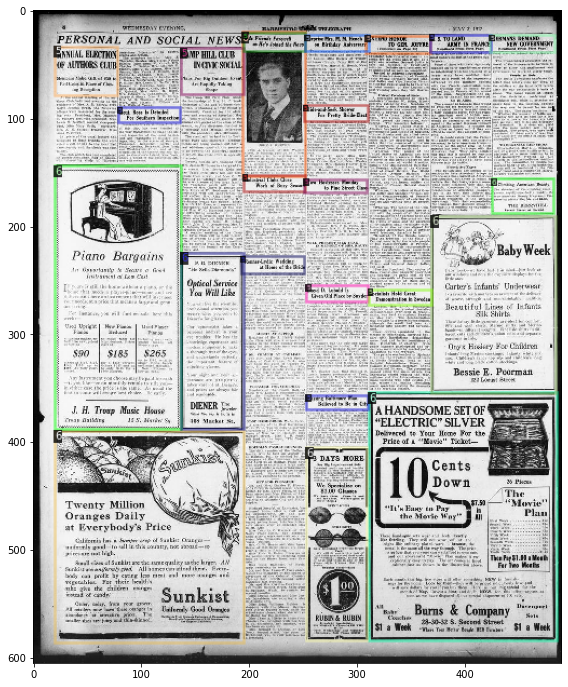

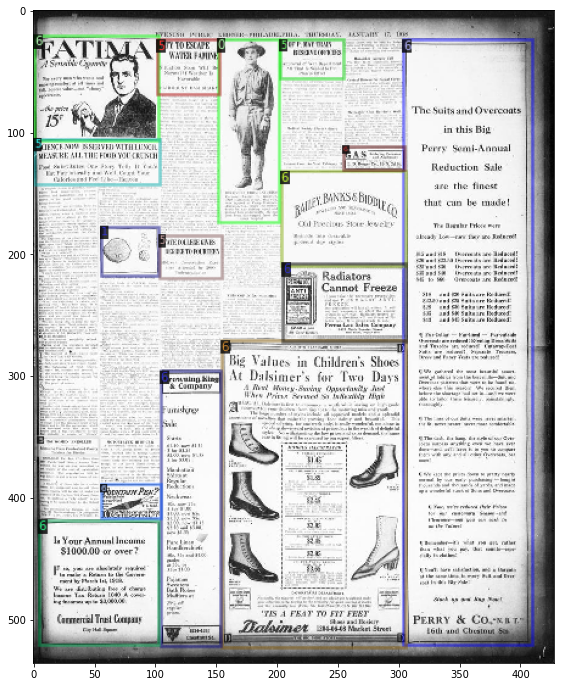

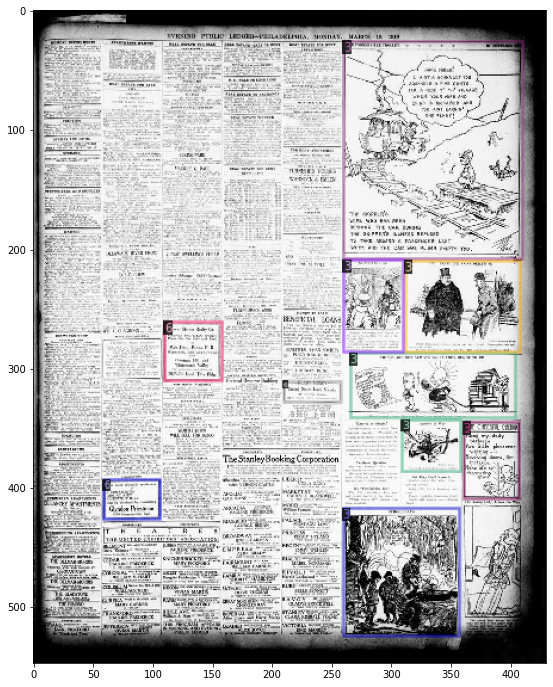

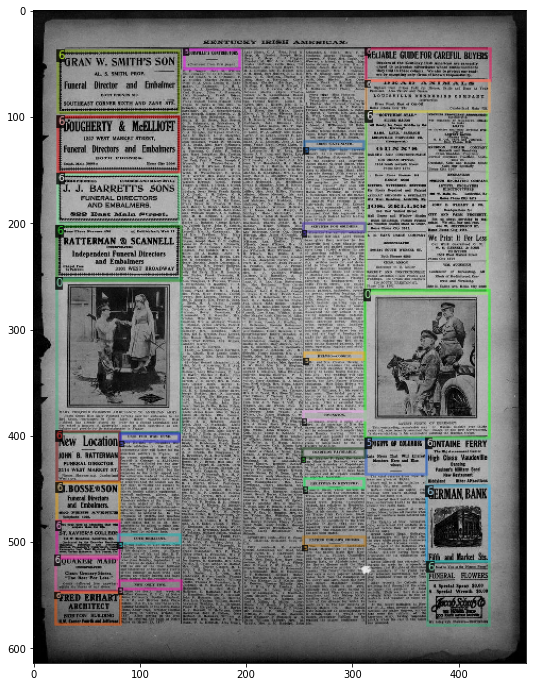

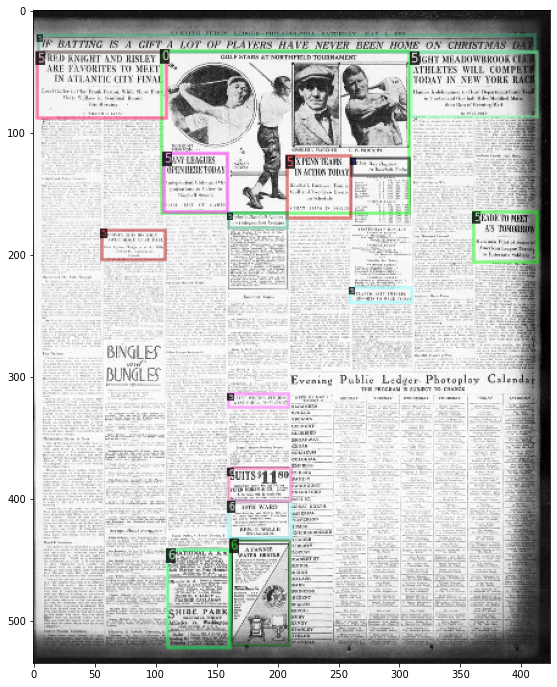

In [ ]:
# sets random seed for reproducibility
random.seed(0)

dataset_dicts = DatasetCatalog.get("beyond_words_train")
my_metadata = MetadataCatalog.get("beyond_words_val")

n_examples_to_display = 5
for d in random.sample(dataset_dicts, n_examples_to_display):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_metadata, scale=0.5)
    v = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,12))
    plt.imshow(v.get_image()[:, :, ::-1])


# Next, we finetune the Faster-RCNN implementation from Detectron2's Model Zoo.

We can pick our choice of pre-trained model here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines.

The 7 classes of visual content are:

- Photograph
- Illustration
- Map
- Comics/Cartoon
- Editorial Cartoon
- Headline
- Advertisement

Below, we finetune "Faster_rcnn_R_50_FPN_3x" and evaluate mean average precision on the held-out data (80%-20% train-val split); for this demo we run for 10 epochs - feel free to run for more epochs and watch the performance on the validation set improve!

Note that there are lines of code below (currently commented out) for saving intermediate model weights and predictions on the validation set to an S3 bucket for later analysis.


In [ ]:
!ls

beyond_words.txt  train_80_percent.json  val_20_percent.json
images		  trainval.json


In [10]:
# sets batch size
batch_size = 16
# sets epoch size accordingly (to convert iterations to epochs)
epoch = math.ceil(2748/float(batch_size))
# sets total number of epochs to train for
epoch_num = 10

cfg = get_cfg()
# loads in correct pre-trained model parameters
cfg.merge_from_file("../..//detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# loads pre-trained model weights (from Model Zoo)
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
# loads in training/val data using the registered COCO instance
cfg.DATASETS.TRAIN = ("beyond_words_train",)
cfg.DATASETS.TEST = ("beyond_words_val",)
# sets number of object classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# makes output directory for weights, etc.
os.makedirs("../model_weights/", exist_ok=True)

# sets output directory for model weights, checkpoints, etc.
cfg.OUTPUT_DIR = '../model_weights/'

# some hyperparameters
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.SOLVER.MAX_ITER = epoch
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8

In [ ]:
!ls

beyond_words.txt  train_80_percent.json  val_20_percent.json
images		  trainval.json


In [ ]:
print("EPOCH 1")


# trains for one epoch
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)  #change here if resuming
trainer.train()

######## FOR SAVING MODEL WEIGHTS AFTER EACH EPOCH TO AN S3 BUCKET #########
# with open("../model_weights/model_final.pth", "rb") as f:
#     s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/model_epoch_1.pth")
############################################################################

# evaluates on validation data after one epoch
# metrics are printed out to console
trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_val", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))

######## FOR SAVING PREDICTIONS ON VALIDATION SET AFTER EACH EPOCH TO AN S3 BUCKET ########
# with open("../model_weights/coco_instances_results.json", "rb") as f:
#     s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/coco_results_epoch_1.json")
###########################################################################################

# trains then evaluates on validation data iteratively for desired number of epochs
for i in range(0, epoch_num-1):
    
    print("EPOCH " + str(i+2))

    # trains again
    cfg.SOLVER.MAX_ITER = epoch*(i+2)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=True)
    trainer.train()
    
    ######## FOR SAVING MODEL WEIGHTS AFTER EACH EPOCH TO AN S3 BUCKET #########
#     with open("../model_weights/model_final.pth", "rb") as f:
#         s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/model_eopch_" + str(i+2) + ".pth")
    ############################################################################   
    
    trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_val", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))

    ######## FOR SAVING PREDICTIONS ON VALIDATION SET AFTER EACH EPOCH TO AN S3 BUCKET ########
#     with open("../model_weights/coco_instances_results.json", "rb") as f:
#         s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/coco_results_epoch_" + str(i+2) + ".json")
    ###########################################################################################

EPOCH 1
[03/08 13:45:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
  

model_final_280758.pkl: 167MB [00:03, 49.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[03/08 13:45:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/08 13:48:05 d2.utils.events]:  eta: 0:16:03  iter: 19  total_loss: 4.466  loss_cls: 2.129  loss_box_reg: 0.6518  loss_rpn_cls: 1.52  loss_rpn_loc: 0.1849  time: 6.4268  data_time: 0.6712  lr: 2.7839e-05  max_mem: 8601M
[03/08 13:50:18 d2.utils.events]:  eta: 0:14:01  iter: 39  total_loss: 2.868  loss_cls: 1.76  loss_box_reg: 0.7468  loss_rpn_cls: 0.1769  loss_rpn_loc: 0.1485  time: 6.5490  data_time: 0.6928  lr: 5.6879e-05  max_mem: 8601M
[03/08 13:52:31 d2.utils.events]:  eta: 0:11:55  iter: 59  total_loss: 2.223  loss_cls: 1.143  loss_box_reg: 0.7672  loss_rpn_cls: 0.1399  loss_rpn_loc: 0.132  time: 6.5885  data_time: 0.8828  lr: 8.592e-05  max_mem: 8601M
[03/08 13:54:44 d2.utils.events]:  eta: 0:09:50  iter: 79  total_loss: 1.958  loss_cls: 0.8934  loss_box_reg: 0.7646  loss_rpn_cls: 0.1192  loss_rpn_loc: 0.1418  time: 6.5939  data_time: 0.6619  lr: 0.00011496  max_mem: 8601M
[03/08 13:56:59 d2.utils.events]:  eta: 0:07:44  iter: 99  total_loss: 1.834  loss_cls: 0.7849  loss_box

# Next, we create a predictor for predicting on examples from the validaton set.

This cell generates a predictor for performing predictions on the validation examples:

In [11]:
# sets the testing confidence threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("beyond_words_val", )

cfg.merge_from_file("../..//detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.WEIGHTS = "../model_weights/model_final.pth"

predictor = DefaultPredictor(cfg)

# Lastly, we display the predictions.

This cell shows some sample predictions in the notebook itself:

In [1]:
n_test_to_display = 20

for d in random.sample(DatasetCatalog.get("beyond_words_val"), n_test_to_display):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("beyond_words_val"), 
                   scale=1.2   )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #v = v.draw_dataset_dict(d)
    plt.figure(figsize=(15,12))
    plt.imshow(v.get_image()[:, :, ::-1])
    
    # if we want to save the images:
    # cv2.imwrite(filepath_here, v.get_image()[:, :, ::-1])


NameError: ignored